# Segmentación de estudiantes e-learning

Cargar datos

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Cargar datos (archivo en la misma carpeta)
path = 'elearning_kmeans.csv'
df = pd.read_csv(path)
print('Shape:', df.shape)
display(df.head())

Shape: (2200, 5)


,horas_estudio_semana,videos_vistos,tests_realizados,dias_conectado_mes,interacciones_foro
0,10.743416,44,36,7,4
1,8.227006,61,20,15,5
2,6.044416,82,24,5,6
3,9.571243,28,5,6,9
4,8.983875,59,28,13,3


EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   horas_estudio_semana  2200 non-null   float64
 1   videos_vistos         2200 non-null   int64  
 2   tests_realizados      2200 non-null   int64  
 3   dias_conectado_mes    2200 non-null   int64  
 4   interacciones_foro    2200 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 86.1 KB


None

Estadísticos resumidos:


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,2200.0,6.052157,2.839514,1.0,3.964221,5.985972,8.036981,16.557204
videos_vistos,2200.0,61.430909,32.894290,5.0,34.000000,62.000000,89.000000,119.000000
tests_realizados,2200.0,20.136364,11.196600,1.0,10.000000,20.000000,30.000000,39.000000
dias_conectado_mes,2200.0,16.986364,7.150993,5.0,11.000000,17.000000,23.000000,29.000000
interacciones_foro,2200.0,6.040909,2.520522,0.0,4.000000,6.000000,8.000000,16.000000


Valores faltantes por columna:
horas_estudio_semana    0
videos_vistos           0
tests_realizados        0
dias_conectado_mes      0
interacciones_foro      0
dtype: int64


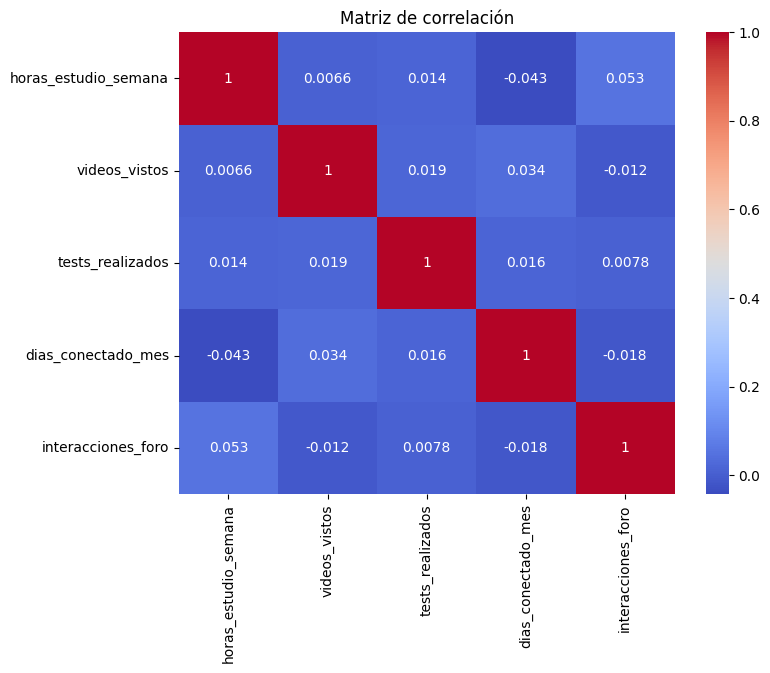

Columnas: ['horas_estudio_semana', 'videos_vistos', 'tests_realizados', 'dias_conectado_mes', 'interacciones_foro']


In [8]:
# Comprobar información del dataframe
display(df.info())

# Estadísticos resumidos
print('Estadísticos resumidos:')
display(df.describe().T)

# Comprobar valores faltantes
print('Valores faltantes por columna:')
print(df.isna().sum())

# Correlaciones y heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

# Columnas
print('Columnas:', list(df.columns))

Escalar

In [9]:
# Selección de características y escalado
features = df.columns.tolist()  # todas las columnas numéricas
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Primeras filas (escaladas):')
display(pd.DataFrame(X_scaled, columns=features).head())

Primeras filas (escaladas):


,horas_estudio_semana,videos_vistos,tests_realizados,dias_conectado_mes,interacciones_foro
0,1.652511,-0.530027,1.417148,-1.396818,-0.809901
1,0.766097,-0.013103,-0.012182,-0.277838,-0.413067
2,-0.002727,0.625451,0.345151,-1.676563,-0.016234
3,1.239609,-1.016544,-1.352179,-1.536690,1.174266
4,1.032707,-0.073917,0.702483,-0.557583,-1.206734


Método del codo

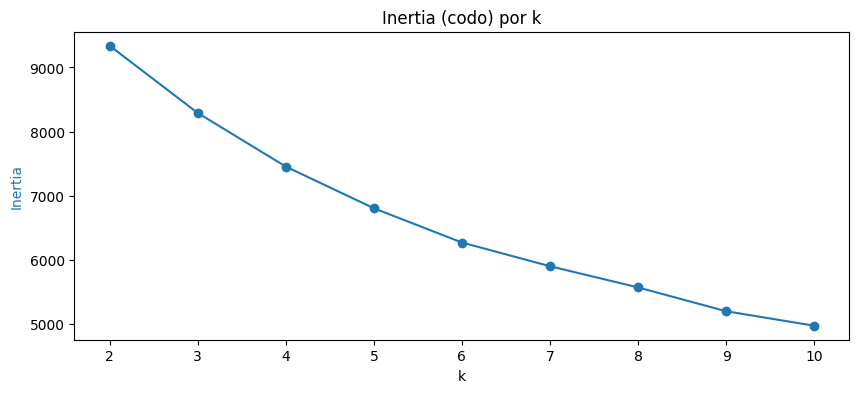

Mejor k (máx silhouette): 10


In [14]:
# Método del codo + silhouette para elegir k
inertias = []
silhouettes = []
K_range = range(2,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(list(K_range), inertias, '-o', color='C0')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia', color='C0')
plt.title('Inertia (codo) por k')
plt.show()

best_k = int(K_range[np.argmax(silhouettes)])
print('Mejor k (máx silhouette):', best_k)

KMeans

Distribución de puntos por cluster:
cluster
0    181
1    223
2    196
3    248
4    218
5    256
6    171
7    233
8    242
9    232
Name: count, dtype: int64


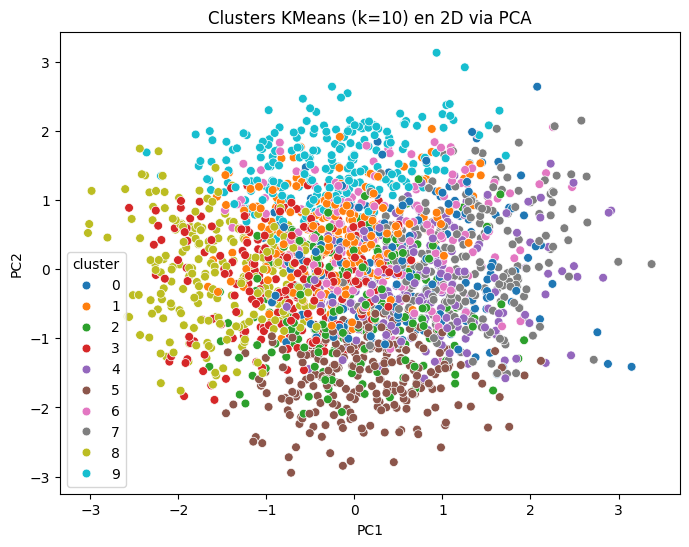

In [11]:
# Ajustar KMeans final con best_k y analizar clusters
k = best_k
km_final = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = km_final.fit_predict(X_scaled)
df['cluster'] = labels

# Centros en escala original
centers_orig = scaler.inverse_transform(km_final.cluster_centers_)
centers_df = pd.DataFrame(centers_orig, columns=features)
centers_df['cluster'] = centers_df.index

print('Distribución de puntos por cluster:')
print(df['cluster'].value_counts().sort_index())

# Visualización 2D con PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=40)
plt.title(f'Clusters KMeans (k={k}) en 2D via PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()

Interpretación

In [12]:
# Interpretación: mostrar centros y estadísticas por cluster

print('Centros de clusters (valores originales):')
display(centers_df)

print('\nResumen estadístico por cluster:')
cluster_summary = df.groupby('cluster')[features].mean()
display(cluster_summary)

# Mostrar descripción para cada cluster
for c in sorted(df['cluster'].unique()):
    print(f'\nCluster {c} - count:', (df['cluster']==c).sum())
    display(df[df['cluster']==c][features].describe().T)

Centros de clusters (valores originales):


,horas_estudio_semana,videos_vistos,tests_realizados,dias_conectado_mes,interacciones_foro,cluster
0,6.155840,50.149171,13.917127,21.779006,10.049724,0
1,6.150855,87.955157,27.695067,10.892377,4.156951,1
2,8.375047,40.153061,9.821429,22.576531,4.948980,2
3,4.402142,31.431452,28.580645,22.250000,4.846774,3
4,7.494608,87.206422,8.403670,11.050459,6.931193,4
5,4.054354,32.867188,11.625000,11.058594,5.421875,5
6,3.741995,73.374269,28.707602,13.251462,8.877193,6
7,8.960595,36.051502,29.390558,11.557940,6.283262,7
8,3.736976,88.917355,13.681818,22.231405,4.210744,8
9,7.723576,90.094828,28.948276,23.607759,6.344828,9



Resumen estadístico por cluster:


,horas_estudio_semana,videos_vistos,tests_realizados,dias_conectado_mes,interacciones_foro
cluster,,,,,
0,6.155840,50.149171,13.917127,21.779006,10.049724
1,6.150855,87.955157,27.695067,10.892377,4.156951
2,8.375047,40.153061,9.821429,22.576531,4.948980
3,4.402142,31.431452,28.580645,22.250000,4.846774
4,7.494608,87.206422,8.403670,11.050459,6.931193
5,4.054354,32.867188,11.625000,11.058594,5.421875
6,3.741995,73.374269,28.707602,13.251462,8.877193
7,8.960595,36.051502,29.390558,11.557940,6.283262
8,3.736976,88.917355,13.681818,22.231405,4.210744



Cluster 0 - count: 181


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,181.0,6.155840,2.294372,1.0,4.59604,6.19236,7.837136,11.239862
videos_vistos,181.0,50.149171,27.216108,5.0,29.00000,49.00000,72.000000,118.000000
tests_realizados,181.0,13.917127,8.080758,1.0,8.00000,13.00000,19.000000,38.000000
dias_conectado_mes,181.0,21.779006,5.189284,5.0,18.00000,22.00000,26.000000,29.000000
interacciones_foro,181.0,10.049724,1.742528,7.0,9.00000,10.00000,11.000000,16.000000



Cluster 1 - count: 223


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,223.0,6.150855,2.283981,1.0,4.508502,6.066791,7.642514,13.161241
videos_vistos,223.0,87.955157,19.445413,41.0,72.500000,90.000000,102.500000,119.000000
tests_realizados,223.0,27.695067,7.017117,10.0,22.000000,28.000000,33.000000,39.000000
dias_conectado_mes,223.0,10.892377,3.750926,5.0,8.000000,11.000000,14.000000,20.000000
interacciones_foro,223.0,4.156951,1.438697,1.0,3.000000,4.000000,5.000000,8.000000



Cluster 2 - count: 196


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,196.0,8.375047,2.100979,2.993672,6.747806,8.183814,9.846669,13.660744
videos_vistos,196.0,40.153061,24.212882,5.000000,18.750000,38.000000,57.000000,115.000000
tests_realizados,196.0,9.821429,6.453284,1.000000,4.000000,9.000000,15.000000,26.000000
dias_conectado_mes,196.0,22.576531,4.499488,8.000000,20.000000,23.000000,26.000000,29.000000
interacciones_foro,196.0,4.948980,1.625896,1.000000,4.000000,5.000000,6.000000,9.000000



Cluster 3 - count: 248


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,248.0,4.402142,1.946185,1.0,2.973353,4.55752,5.669572,10.516392
videos_vistos,248.0,31.431452,19.149828,5.0,15.000000,30.50000,43.000000,84.000000
tests_realizados,248.0,28.580645,7.042493,8.0,23.000000,29.00000,35.000000,39.000000
dias_conectado_mes,248.0,22.250000,4.684586,8.0,19.000000,22.00000,26.000000,29.000000
interacciones_foro,248.0,4.846774,1.761230,0.0,4.000000,5.00000,6.000000,9.000000



Cluster 4 - count: 218


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,218.0,7.494608,2.391907,1.0,5.711605,7.283183,9.107925,13.844125
videos_vistos,218.0,87.206422,20.374570,28.0,74.000000,90.000000,104.000000,119.000000
tests_realizados,218.0,8.403670,5.107362,1.0,4.000000,7.500000,12.000000,22.000000
dias_conectado_mes,218.0,11.050459,4.228739,5.0,8.000000,11.000000,14.000000,23.000000
interacciones_foro,218.0,6.931193,2.074608,2.0,6.000000,7.000000,8.000000,14.000000



Cluster 5 - count: 256


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,256.0,4.054354,1.972926,1.0,2.548439,3.999374,5.562795,9.335918
videos_vistos,256.0,32.867188,18.298986,5.0,17.750000,32.000000,47.000000,91.000000
tests_realizados,256.0,11.625000,7.367656,1.0,6.000000,11.000000,16.000000,31.000000
dias_conectado_mes,256.0,11.058594,4.452856,5.0,7.000000,10.000000,14.000000,23.000000
interacciones_foro,256.0,5.421875,1.836917,1.0,4.000000,5.000000,7.000000,11.000000



Cluster 6 - count: 171


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,171.0,3.741995,1.905780,1.0,2.263284,3.78766,5.070154,9.623001
videos_vistos,171.0,73.374269,25.268912,7.0,58.000000,76.00000,91.000000,119.000000
tests_realizados,171.0,28.707602,6.562541,15.0,24.000000,29.00000,34.000000,39.000000
dias_conectado_mes,171.0,13.251462,5.352398,5.0,9.000000,13.00000,17.000000,27.000000
interacciones_foro,171.0,8.877193,1.674060,6.0,8.000000,9.00000,10.000000,14.000000



Cluster 7 - count: 233


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,233.0,8.960595,2.041375,4.066481,7.55358,8.96901,10.390289,16.557204
videos_vistos,233.0,36.051502,20.930857,5.000000,19.00000,33.00000,50.000000,100.000000
tests_realizados,233.0,29.390558,6.899356,8.000000,24.00000,31.00000,35.000000,39.000000
dias_conectado_mes,233.0,11.557940,4.827841,5.000000,8.00000,11.00000,15.000000,25.000000
interacciones_foro,233.0,6.283262,2.158888,0.000000,5.00000,6.00000,8.000000,13.000000



Cluster 8 - count: 242


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,242.0,3.736976,1.909784,1.0,2.293938,3.607974,5.179549,9.560761
videos_vistos,242.0,88.917355,20.167385,41.0,73.000000,90.000000,107.000000,119.000000
tests_realizados,242.0,13.681818,8.091412,1.0,7.000000,13.000000,19.000000,38.000000
dias_conectado_mes,242.0,22.231405,4.292733,7.0,20.000000,22.000000,25.750000,29.000000
interacciones_foro,242.0,4.210744,1.740716,0.0,3.000000,4.000000,6.000000,8.000000



Cluster 9 - count: 232


,count,mean,std,min,25%,50%,75%,max
horas_estudio_semana,232.0,7.723576,2.172157,1.885855,6.255336,7.872581,9.050382,13.781702
videos_vistos,232.0,90.094828,18.617582,27.000000,78.000000,91.000000,105.250000,119.000000
tests_realizados,232.0,28.948276,7.063527,6.000000,24.000000,30.000000,35.000000,39.000000
dias_conectado_mes,232.0,23.607759,3.758572,14.000000,21.000000,24.000000,27.000000,29.000000
interacciones_foro,232.0,6.344828,1.884562,1.000000,5.000000,6.000000,7.000000,12.000000
